# Research Task - Statewide VRM/VRH by Operator per UZA [#1536](https://github.com/cal-itp/data-analyses/issues/1536)

**Task:**
<br>develop a statewide, analysis presented as a notebook, with an interactive map + a table of statewide VRH and VRM aggregated for each operator in each FTA UZA (and outside of those areas, in each RTPA or county).

**Metrics:** 
<br>total VRM and VRH in a UZA, percent of each metric that is provided by a given operator


**Expected Outputs / Findings:**
<br>notebook portfolio site with a map of all UZAs, with stats that pop up in the tooltip as one mouses over a UZA. Plus a table.

## Migrate initial statewide work from sjcog service anaylsis

In [1]:
import requests
import pandas as pd
from calitp_data_analysis.sql import query_sql
import geopandas as gpd
import gcsfs
import google.auth

credentials, project = google.auth.default()
fs = gcsfs.GCSFileSystem(token=credentials)

pd.set_option('display.max_rows', None)

## Latest Transit Service Intensity (TSI) data
should include operators

In [2]:
# tsi_agency = "gs://calitp-analytics-data/data-analyses/transit_service_intensity/test_tsi_agency_2025-04-16.parquet"
tsi_agency_2 = "gs://calitp-analytics-data/data-analyses/transit_service_intensity/test_tsi_agency_2025-07-16.parquet"

In [3]:
# read in parquet as gdf
tsi_data = gpd.read_parquet(
    tsi_agency_2,
    storage_options={"token": credentials.token},
)

In [4]:
tsi_data.head()

,tract,pop_sq_mi,population,geometry,schedule_gtfs_dataset_key,daily_vrm_miles,daily_vrh_hours
0,06001400100,1174.735672,3120,"POLYGON ((-197090.096 -12468.283, -196909.112 ...",a8d5f90bfd689badb7e1deb041408e96,179.5,2.9
1,06001400100,1174.735672,3120,"POLYGON ((-197090.096 -12468.283, -196909.112 ...",c499f905e33929a641f083dad55c521e,3.3,0.3
2,06001400200,8729.842564,2007,"POLYGON ((-196982.196 -15963.566, -196992.931 ...",8a1405af8da1379acc062e346187ac98,227.6,5.2
3,06001400200,8729.842564,2007,"POLYGON ((-196982.196 -15963.566, -196992.931 ...",c499f905e33929a641f083dad55c521e,388.7,37.7
4,06001400300,11819.185546,5051,"POLYGON ((-197350.929 -16712.642, -197950.200 ...",8a1405af8da1379acc062e346187ac98,227.6,5.2


<Axes: >

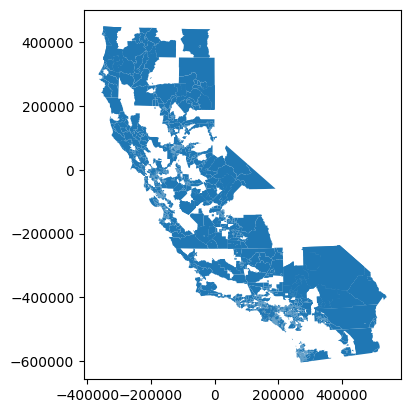

In [5]:
tsi_data.plot()

In [6]:
## Add agency name to table
query_dim_gtfs_datasets = """
SELECT
  key,
  name,
  analysis_name,
  type,
  regional_feed_type
FROM `cal-itp-data-infra.mart_transit_database.dim_gtfs_datasets`
WHERE
  type = "schedule"
"""

gtfs_dataset_names = query_sql(
    query_dim_gtfs_datasets,
    as_df = True
)

gtfs_dataset_names= gtfs_dataset_names.rename(columns ={
    "name":"gtfs_dataset_name",
    "type":"gtfs_type"
})

In [7]:
gtfs_dataset_names.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2693 entries, 0 to 2692
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   key                 2693 non-null   object
 1   gtfs_dataset_name   2693 non-null   object
 2   analysis_name       251 non-null    object
 3   gtfs_type           2693 non-null   object
 4   regional_feed_type  305 non-null    object
dtypes: object(5)
memory usage: 105.3+ KB


In [8]:
# test merge 
test_merge = tsi_data.merge(
    gtfs_dataset_names,
    left_on = "schedule_gtfs_dataset_key",
    right_on = "key",
    how = "left",
    indicator = True
)

In [9]:
display(
    test_merge.info(),
    test_merge["_merge"].value_counts(),
    test_merge["regional_feed_type"].value_counts(dropna=False),
    test_merge.head()
)

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 10273 entries, 0 to 10272
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   tract                      10273 non-null  object  
 1   pop_sq_mi                  10273 non-null  float64 
 2   population                 10273 non-null  int64   
 3   geometry                   10273 non-null  geometry
 4   schedule_gtfs_dataset_key  10273 non-null  object  
 5   daily_vrm_miles            10273 non-null  float64 
 6   daily_vrh_hours            10273 non-null  float64 
 7   key                        10273 non-null  object  
 8   gtfs_dataset_name          10273 non-null  object  
 9   analysis_name              0 non-null      object  
 10  gtfs_type                  10273 non-null  object  
 11  regional_feed_type         2082 non-null   object  
 12  _merge                     10273 non-null  category
dtypes: category(1), float64

None

both          10273
left_only         0
right_only        0
Name: _merge, dtype: int64

None                      8191
Regional Subfeed          1904
Combined Regional Feed     178
Name: regional_feed_type, dtype: int64

,tract,pop_sq_mi,population,geometry,schedule_gtfs_dataset_key,daily_vrm_miles,daily_vrh_hours,key,gtfs_dataset_name,analysis_name,gtfs_type,regional_feed_type,_merge
0,06001400100,1174.735672,3120,"POLYGON ((-197090.096 -12468.283, -196909.112 ...",a8d5f90bfd689badb7e1deb041408e96,179.5,2.9,a8d5f90bfd689badb7e1deb041408e96,Bear Schedule,None,schedule,None,both
1,06001400100,1174.735672,3120,"POLYGON ((-197090.096 -12468.283, -196909.112 ...",c499f905e33929a641f083dad55c521e,3.3,0.3,c499f905e33929a641f083dad55c521e,Bay Area 511 AC Transit Schedule,None,schedule,Regional Subfeed,both
2,06001400200,8729.842564,2007,"POLYGON ((-196982.196 -15963.566, -196992.931 ...",8a1405af8da1379acc062e346187ac98,227.6,5.2,8a1405af8da1379acc062e346187ac98,Bay Area 511 BART Schedule,None,schedule,Regional Subfeed,both
3,06001400200,8729.842564,2007,"POLYGON ((-196982.196 -15963.566, -196992.931 ...",c499f905e33929a641f083dad55c521e,388.7,37.7,c499f905e33929a641f083dad55c521e,Bay Area 511 AC Transit Schedule,None,schedule,Regional Subfeed,both
4,06001400300,11819.185546,5051,"POLYGON ((-197350.929 -16712.642, -197950.200 ...",8a1405af8da1379acc062e346187ac98,227.6,5.2,8a1405af8da1379acc062e346187ac98,Bay Area 511 BART Schedule,None,schedule,Regional Subfeed,both


In [10]:
test_merge[test_merge["gtfs_dataset_name"].str.contains("511")]["gtfs_dataset_name"].unique().tolist()

['Bay Area 511 AC Transit Schedule',
 'Bay Area 511 BART Schedule',
 'Bay Area 511 Emery Go-Round Schedule',
 'Bay Area 511 Emery Express Schedule',
 'Bay Area 511 Capitol Corridor Schedule',
 'Bay Area 511 San Francisco Bay Ferry Schedule',
 'Bay Area 511 Union City Transit Schedule',
 'Bay Area 511 Dumbarton Express Schedule',
 'Bay Area 511 ACE Schedule',
 'Bay Area 511 County Connection Schedule',
 'Bay Area 511 Tri-Valley Wheels Schedule',
 'Bay Area 511 Tri Delta Schedule',
 'Bay Area 511 WestCAT Schedule',
 'Bay Area 511 Golden Gate Transit Schedule',
 'Bay Area 511 Marin Schedule',
 'Bay Area 511 Golden Gate Ferry Schedule',
 'Bay Area 511 Angel Island-Tiburon Ferry Schedule',
 'Bay Area 511 Muni Schedule',
 'Bay Area 511 PresidiGo Schedule',
 'Bay Area 511 Treasure Island Ferry Schedule',
 'Bay Area 511 Mission Bay Schedule',
 'Bay Area 511 Golden Gate Park Shuttle Schedule',
 'Bay Area 511 SamTrans Schedule',
 'Bay Area 511 Caltrain Schedule',
 'Bay Area 511 Commute.org Sched

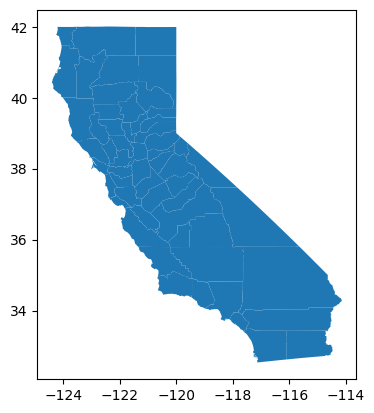

In [11]:
# CA Counties
county_url="https://caltrans-gis.dot.ca.gov/arcgis/rest/services/CHboundary/County_Boundaries/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson"

county_map=gpd.read_file(
    county_url,
    storage_options={"token": credentials.token}
)
county_map.plot()

# just San Joaquin
sj = county_map[county_map["NAME10"]=="San Joaquin"]
#sj.plot()

In [12]:
# CA state UZA map
uza_url="https://caltrans-gis.dot.ca.gov/arcgis/rest/services/CHboundary/Adjusted_Urban_Area/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson"
uza_map=gpd.read_file(
    uza_url,
    storage_options={"token": credentials.token}
)


# urban areas in San Joaquin coutny
uza_list =[
    "Stockton, CA",
    "Tracy--Mountain House, CA",
    "Manteca, CA",
    "Lodi, CA"
]

sj_uza= uza_map[uza_map["NAME"].isin(uza_list)]

#sj_uza.plot()

<Axes: >

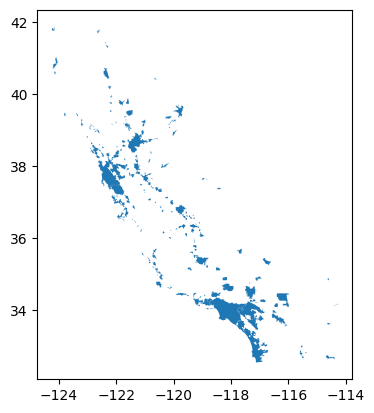

In [13]:
uza_map.plot()

<Axes: >

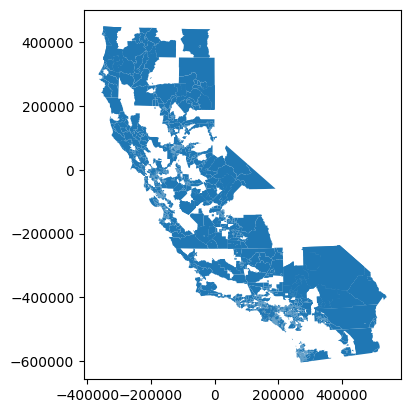

In [14]:
tsi_data.plot()

In [15]:
# over the census tracks on the UZA 
sj_uza_tsi_overlay = sj_uza.overlay(tsi_data.to_crs("EPSG:4326"),how='intersection')

In [16]:
ca_uza_tsi_overlay = uza_map.overlay(tsi_data.to_crs("EPSG:4326"),how='intersection')

In [17]:
test_overlay = uza_map.overlay(test_merge.to_crs("EPSG:4326"),how='intersection')

In [ ]:
ca_uza_tsi_overlay.explore()
#sj_uza_tsi_overlay.explore()

<Axes: >

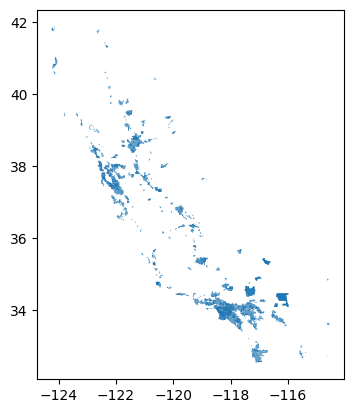

In [19]:
test_overlay.plot()

# How much of the census tract is in the UZA map? 
and vise-versa

<Axes: >

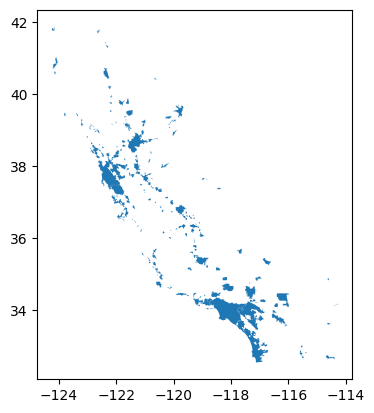

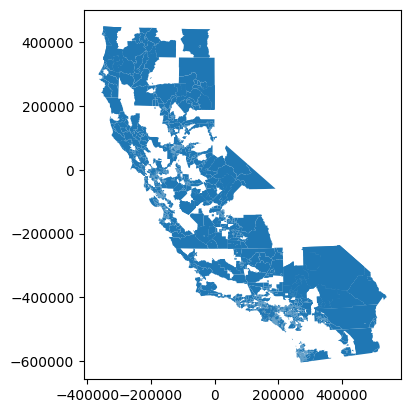

In [22]:
uza_map.plot(),
tsi_data.plot()

In [ ]:
# vise vera
uza_tract = uza_map.to_crs("EPSG:4326").overlay(tsi_data.to_crs("EPSG:4326"),how='intersection')
tract_uza = tsi_data.to_crs("EPSG:4326").overlay(uza_map.to_crs("EPSG:4326"),how='intersection')

/tmp/ipykernel_869/2363609618.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  uza_tract["geometry"].area.sum(),
/tmp/ipykernel_869/2363609618.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  tract_uza.geometry.area.sum()


3.5173883642734083

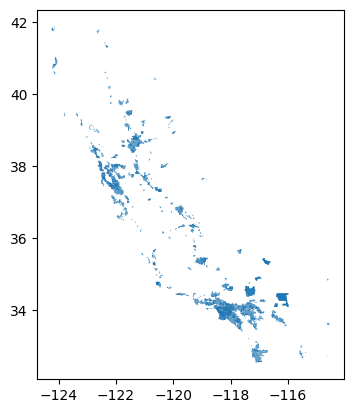

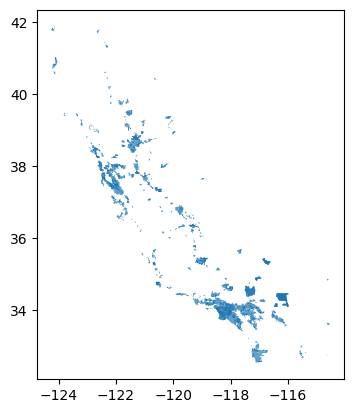

In [27]:
uza_tract.plot(),
tract_uza.plot(),
# compare area
uza_tract["geometry"].area.sum(),
tract_uza.geometry.area.sum()

# How many gtfs keys are in each uza?

In [ ]:
test_overlay.groupby("NAME").agg({
    "name":"nunique",
    "daily_vrm_miles":"sum",
    "daily_vrh_hours":"sum"
}).reset_index()

## What is the vrm/vrh per gtfs key, for each UZA?

In [ ]:
ca_uza_tsi_overlay.groupby([
    "NAME",
    "schedule_gtfs_dataset_key"
]).agg({
    #"schedule_gtfs_dataset_key":"nunique",
    "daily_vrm_miles":"sum",
    "daily_vrh_hours":"sum"
})#.reset_index()

## NTD STIC table

In [ ]:
stic_url = "gs://calitp-analytics-data/data-analyses/ntd/service_analysis/FY-2025-5307-STIC-NTD-Data-09-01-2024.xlsx"

stic_data = pd.read_excel(
    stic_url,
    sheet_name="STIC by Agency",
    header=1,
    usecols=list(range(0,11))
)

In [ ]:
display(
    stic_data.info(),
    stic_data.head(),
)

# Where can I get California Census Block geometry data?

In [6]:
# can get CA census block data from Redistricting Data (PL 94-171)
# state› county› tract› block
ca_blocks = "https://api.census.gov/data/2020/dec/pl?get=NAME&for=block:*&in=state:06&in=county:*&in=tract:*&key=YOUR_KEY_GOES_HERE"

In [ ]:
# can get CA shape files from TIGER/Line Geodatabases?
# https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.2022.html#list-tab-790442341"

In [7]:
!pip show fiona

Name: fiona
Version: 1.10.1
Summary: Fiona reads and writes spatial data files
Home-page: 
Author: Sean Gillies
Author-email: 
License: BSD 3-Clause
Location: /opt/conda/lib/python3.11/site-packages
Requires: attrs, certifi, click, click-plugins, cligj
Required-by: geopandas


# Can i change Eric's initial work to get census block instead of tract?